# STOCK PREDICTION ML

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from yahooquery import search
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV

from eodhd import APIClient

## YFINANCE

Nos fijamos siempre en `'symbol'`

In [28]:
result = search('tesla')
result

{'explains': [],
 'count': 15,
 'quotes': [{'exchange': 'NMS',
   'shortname': 'Tesla, Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'TSLA',
   'index': 'quotes',
   'score': 39584.0,
   'typeDisp': 'Equity',
   'longname': 'Tesla, Inc.',
   'exchDisp': 'NASDAQ',
   'sector': 'Consumer Cyclical',
   'sectorDisp': 'Consumer Cyclical',
   'industry': 'Auto Manufacturers',
   'industryDisp': 'Auto Manufacturers',
   'dispSecIndFlag': True,
   'isYahooFinance': True},
  {'exchange': 'NEO',
   'shortname': 'TESLA, INC. CDR (CAD HEDGED)',
   'quoteType': 'EQUITY',
   'symbol': 'TSLA.NE',
   'index': 'quotes',
   'score': 20040.0,
   'typeDisp': 'Equity',
   'longname': 'Tesla, Inc.',
   'exchDisp': 'NEO',
   'sector': 'Consumer Cyclical',
   'sectorDisp': 'Consumer Cyclical',
   'industry': 'Auto Manufacturers',
   'industryDisp': 'Auto Manufacturers',
   'isYahooFinance': True},
  {'exchange': 'SAO',
   'shortname': 'TESLA INC   DRN',
   'quoteType': 'EQUITY',
   'symbol': 'TSLA34.SA',
   '

Descargamos el historial de los ultimos 3 años de TESLA

In [29]:
tesla = yf.Ticker('TSLA')
tesla = tesla.history(period = '3y', interval = '1d')

In [30]:
tesla.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-08-08 00:00:00-04:00,321.429993,335.149994,320.980011,329.649994,91200300,0.0,0.0
2025-08-11 00:00:00-04:00,335.000000,346.640015,334.149994,339.029999,105320200,0.0,0.0
2025-08-12 00:00:00-04:00,345.000000,345.260010,332.940002,340.839996,80522100,0.0,0.0
2025-08-13 00:00:00-04:00,341.500000,348.980011,338.200012,339.380005,67838900,0.0,0.0
2025-08-14 00:00:00-04:00,335.760010,340.470001,330.399994,335.579987,75000700,0.0,0.0
2025-08-15 00:00:00-04:00,337.660004,339.299988,327.019989,330.559998,74319800,0.0,0.0
2025-08-18 00:00:00-04:00,329.619995,336.269989,329.589996,335.160004,56956600,0.0,0.0
2025-08-19 00:00:00-04:00,335.790009,340.549988,327.850006,329.309998,75956000,0.0,0.0
2025-08-20 00:00:00-04:00,329.220001,331.369995,314.600006,323.899994,77481800,0.0,0.0


Nos quedamos con la columna que nos interesa

In [31]:
df = tesla[['Close']].copy()
df

,Close
Date,
2022-08-22 00:00:00-04:00,289.913330
2022-08-23 00:00:00-04:00,296.453339
2022-08-24 00:00:00-04:00,297.096680
2022-08-25 00:00:00-04:00,296.070007
2022-08-26 00:00:00-04:00,288.089996
...,...
2025-08-15 00:00:00-04:00,330.559998
2025-08-18 00:00:00-04:00,335.160004
2025-08-19 00:00:00-04:00,329.309998


Miramos la grafica de la columna `Close` de dos maneras diferentes

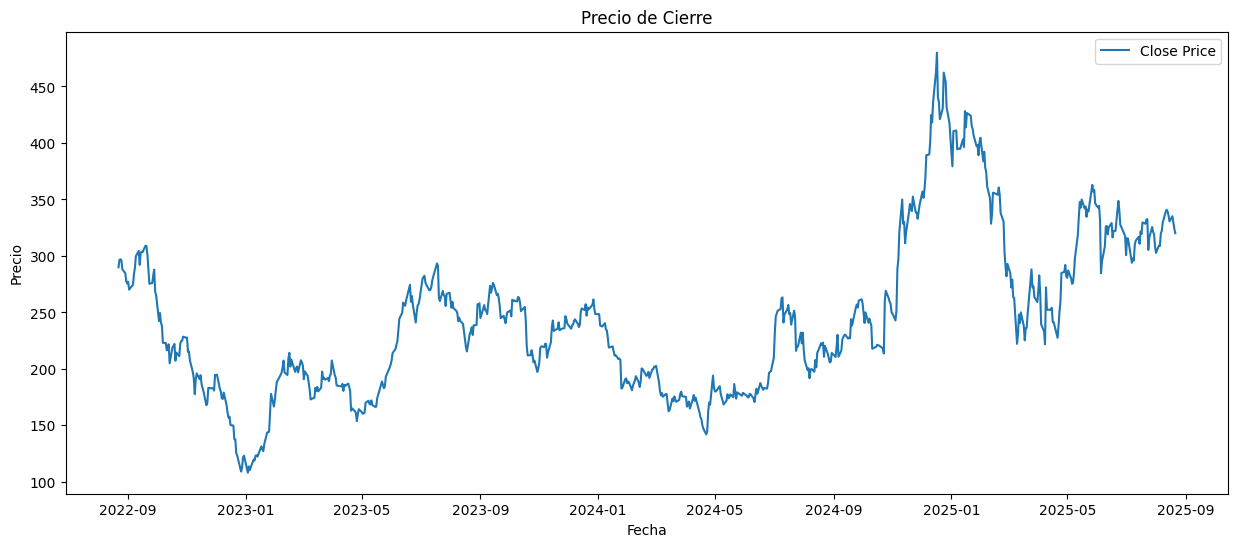

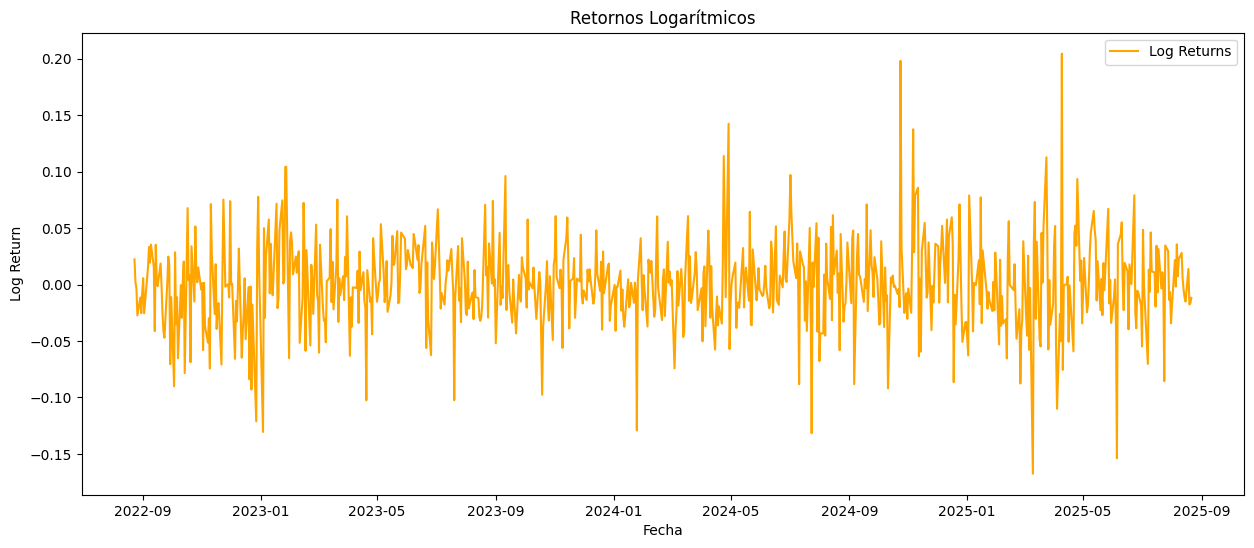

In [32]:
# 1. Serie original (Close)
plt.figure(figsize=(15,6))
plt.plot(df['Close'], label='Close Price')
plt.title("Precio de Cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.show()

# 2. Retornos logarítmicos
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

plt.figure(figsize=(15,6))
plt.plot(df['LogReturn'], label='Log Returns', color='orange')
plt.title("Retornos Logarítmicos")
plt.xlabel("Fecha")
plt.ylabel("Log Return")
plt.legend()
plt.show()

### SERIE ORIGINAL

In [33]:
df.shape

(753, 2)

In [34]:
serie_original = df[['Close']].copy()
serie_original = serie_original.iloc[:-1]
serie_original

,Close
Date,
2022-08-22 00:00:00-04:00,289.913330
2022-08-23 00:00:00-04:00,296.453339
2022-08-24 00:00:00-04:00,297.096680
2022-08-25 00:00:00-04:00,296.070007
2022-08-26 00:00:00-04:00,288.089996
...,...
2025-08-14 00:00:00-04:00,335.579987
2025-08-15 00:00:00-04:00,330.559998
2025-08-18 00:00:00-04:00,335.160004


Creamos una variable que se llama `ventana_inicial` para que el `Walk-forward Validation` sepa cuántos datos usará para el primer entrenamiento

In [35]:
ventana_inicial = 500

if len(serie_original) <= ventana_inicial:
    raise ValueError("No hay suficientes datos para la validación.")

En ``walk-forward``, la lógica es:

1. Entreno un modelo con los datos desde t₁ hasta tₖ → esa parte inicial es la ventana_inicial.

2. Predigo el siguiente punto (tₖ₊₁).

3. Añado el dato real al entrenamiento.

4. Repito: entreno desde t₁ hasta tₖ₊₁ → predigo tₖ₊₂, etc.

**¿Cómo funciona internamente?**

``Train inicial`` → toma los primeros ventana_inicial datos

``Test`` → predice el dato siguiente (h=1)

``Añade ese dato a train`` → vuelve a entrenar → predice el próximo

Repite hasta llegar al final de la serie

In [36]:
cv = SlidingWindowForecastCV(window_size=ventana_inicial, step=1, h=1)
errors, preds, trues = [], [], []

Ahora usamos ``Walk-forward CV con SlidingWindowForecastCV``

``SlidingWindowForecastCV`` solo define cómo se va a mover la ventana de entrenamiento/prueba, pero todavía no sabe sobre qué datos trabajar

``window_size = ventana_inicial`` → Le dice: «toma los primeros **ventana_inicial** valores de la serie como entrenamiento»»

``step = 1`` → Después de predecir, mueve la ventana 1 dato hacia adelante, para incluir el siguiente punto en el entrenamiento y repetir el proceso.

``h = 1``→ Horizonte de predicción = 1 → «solo quiero predecir el siguiente dato cada vez»»
(también se conoce como 1-step ahead forecasting).

``cv`` es un objeto de tipo ``SlidingWindowForecastCV``, que sabe cómo mover una ventana por una serie temporal.

``.split(logret)`` corta tu serie de ``LogReturn`` en ventanas temporales, simulando un proceso de **entrenar → predecir → avanzar → volver a entrenar.**

En cada paso del bucle te devuelve dos cosas:

``train``: una ventana de datos históricos (por ejemplo, los primeros 500 logreturns)

``test``: el dato siguiente justo después de esa ventana → lo que quieres predecir

In [37]:
for train, test in cv.split(serie_original):
    m = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
    p = m.predict(n_periods=1)[0]
    t = test[0]

    preds.append(p)
    trues.append(t)
    errors.append((t - p)**2)

rmse = np.sqrt(np.mean(errors))
print(f"\nRMSE walk-forward: {rmse}")

c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d


RMSE walk-forward: 3.7587560684407496e-06


c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


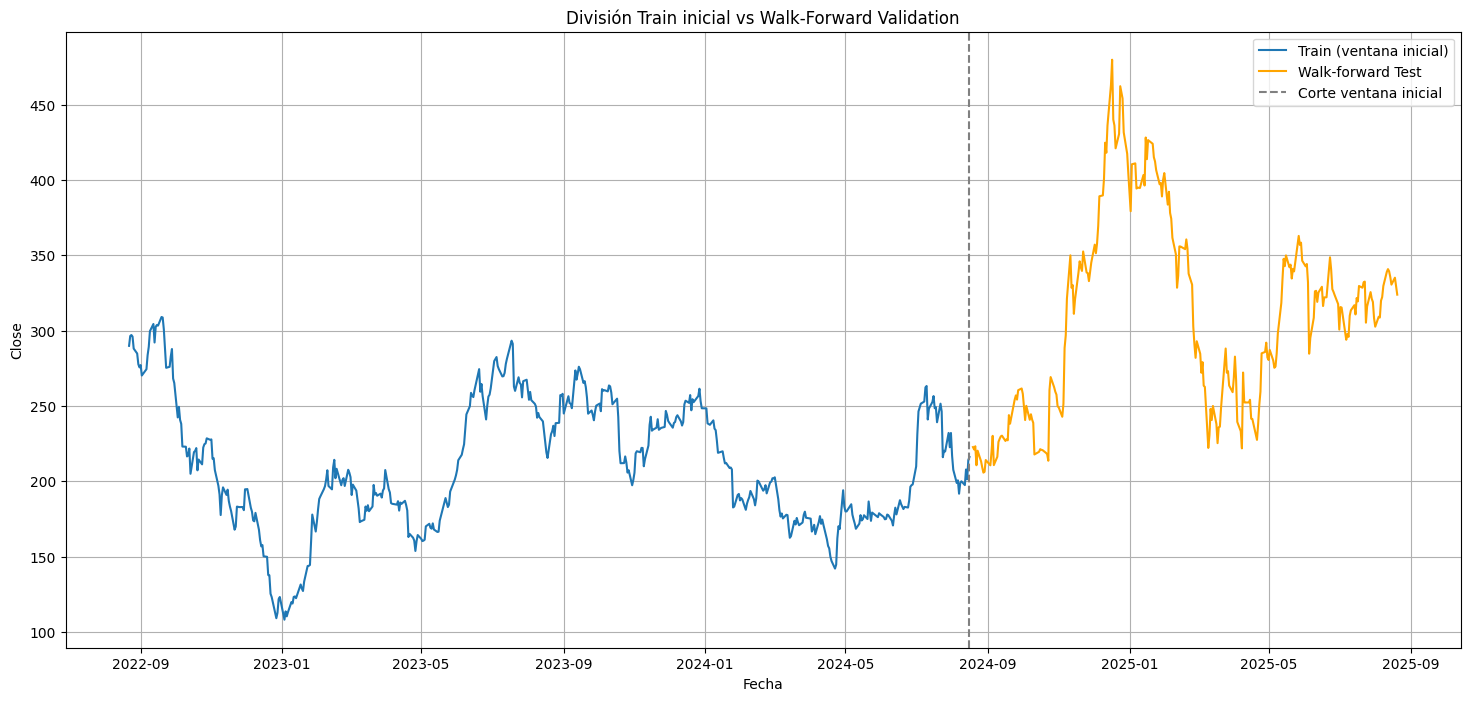

In [38]:
# Definimos las zonas
train = serie_original.iloc[:ventana_inicial]
test  = serie_original.iloc[ventana_inicial:]

# Dibujamos
plt.figure(figsize=(18,8))
plt.plot(train.index, train, label='Train (ventana inicial)')
plt.plot(test.index, test, label='Walk-forward Test', color='orange')
plt.axvline(train.index[-1], linestyle='--', color='gray', label='Corte ventana inicial')
plt.title('División Train inicial vs Walk-Forward Validation')
plt.xlabel('Fecha')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

``serie`` → es tu serie completa de precios de cierre **(Close)**.

``auto_arima`` busca automáticamente los mejores **hiperparámetros (p,d,q)** para un modelo ARIMA que se ajuste a esa serie.

``seasonal=False`` → le decimos que no busque estacionalidad (porque trabajamos con datos diarios y no queremos SARIMA).

``stepwise=True`` → hace que la búsqueda sea más rápida usando un método inteligente.

El resultado (**final_model**) ya queda entrenado con TODOS tus datos históricos.

In [39]:
final_model = auto_arima(serie_original, seasonal=False, stepwise=True, suppress_warnings=True)

pred = final_model.predict(n_periods=1)
pred_value = pred.iloc[0]

print(f"\nPredicción Close: {pred_value:.4f}")

c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d


Predicción Close: 323.9639


c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\yanju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### SERIE LOG RETURN

Un LogReturn = 0.01 → +1% de subida aprox.

Un LogReturn = -0.02 → -2% de bajada aprox.

Valores cercanos a 0 → poca variación.

Es el porcentaje de subida/bajada del dia anterior al actual

In [40]:
serie_original

,Close
Date,
2022-08-22 00:00:00-04:00,289.913330
2022-08-23 00:00:00-04:00,296.453339
2022-08-24 00:00:00-04:00,297.096680
2022-08-25 00:00:00-04:00,296.070007
2022-08-26 00:00:00-04:00,288.089996
...,...
2025-08-14 00:00:00-04:00,335.579987
2025-08-15 00:00:00-04:00,330.559998
2025-08-18 00:00:00-04:00,335.160004


In [41]:
logret = np.log(serie_original / serie_original.shift(1)).dropna()
logret

,Close
Date,
2022-08-23 00:00:00-04:00,0.022308
2022-08-24 00:00:00-04:00,0.002168
2022-08-25 00:00:00-04:00,-0.003462
2022-08-26 00:00:00-04:00,-0.027323
2022-08-29 00:00:00-04:00,-0.011415
...,...
2025-08-14 00:00:00-04:00,-0.011260
2025-08-15 00:00:00-04:00,-0.015072
2025-08-18 00:00:00-04:00,0.013820


## EODHD

#### Installing library

In [39]:
%pip install eodhd

Note: you may need to restart the kernel to use updated packages.


In [40]:
api = APIClient(api_key='68a888ecbf2185.97717291')

In [41]:
TICKERS = ["AAPL.US", "GOOGL.US", "TSLA.US", "JNJ.US", "JPM.US", "ITX.MC"]

**AAPL.US → Apple Inc.** (tecnología, iPhone, iPad, Mac).

**GOOGL.US → Alphabet Inc. Clase A** (matriz de Google, YouTube, Android).

**TSLA.US → Tesla Inc.** (vehículos eléctricos, baterías, energía).

**JNJ.US → Johnson & Johnson** (farmacéutica y productos de consumo, muy estable).

**JPM.US → JPMorgan Chase & Co.** (banco de inversión y comercial, uno de los más grandes del mundo).

**ITX.MC → Inditex S.A.** (España, grupo textil dueño de Zara, Pull&Bear, Massimo Dutti, etc., cotiza en la Bolsa de Madrid).

In [23]:
for i in TICKERS:
    df = pd.DataFrame(api.get_eod_historical_stock_market_data(symbol= i, period='d', from_date='2010-01-01'))
    df.to_csv(f'{i}.csv', index=False)

NameError: name 'TICKERS' is not defined

#### Data Analysis

In [24]:
df = pd.read_csv('AAPL.US.csv', parse_dates=['date'])    #asegurar que los datos estan en orden
df = df.sort_values('date').reset_index(drop=True)
df

,date,open,high,low,close,adjusted_close,volume
0,2010-01-04,213.43000000,214.49960000,212.38000000,214.00960000,6.42460000,493729600
1,2010-01-05,214.60040000,215.58880000,213.25080000,214.37920000,6.43570000,601904800
2,2010-01-06,214.37920000,215.23040000,210.75040000,210.96880000,6.33330000,552160000
3,2010-01-07,211.75000000,211.99920000,209.05080000,210.57960000,6.32160000,477131200
4,2010-01-08,210.29960000,211.99920000,209.05920000,211.97960000,6.36370000,447610800
...,...,...,...,...,...,...,...
3928,2025-08-15,234.00000000,234.28000000,229.34000000,231.59000000,231.59000000,56038700
3929,2025-08-18,231.70000000,233.12000000,230.11000000,230.89000000,230.89000000,37476200
3930,2025-08-19,231.28000000,232.87000000,229.35000000,230.56000000,230.56000000,39402600
3931,2025-08-20,229.98000000,230.47000000,225.77000000,226.01000000,226.01000000,42263900


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3933 non-null   datetime64[ns]
 1   open            3933 non-null   float64       
 2   high            3933 non-null   float64       
 3   low             3933 non-null   float64       
 4   close           3933 non-null   float64       
 5   adjusted_close  3933 non-null   float64       
 6   volume          3933 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 215.2 KB


In [26]:
df.describe()

,date,open,high,low,close,adjusted_close,volume
count,3933,3933.00000000,3933.00000000,3933.00000000,3933.00000000,3933.00000000,3933.00000000
mean,2017-10-25 10:33:46.544622592,243.78866707,246.18849499,241.30922248,243.83663707,73.36474078,222948588.42308670
min,2010-01-04 00:00:00,90.00000000,90.70000000,89.47000000,90.28000000,5.76540000,23234700.00000000
25%,2013-11-27 00:00:00,141.60000000,143.16000000,140.23000000,141.80000000,17.97910000,80655200.00000000
50%,2017-10-24 00:00:00,187.72000000,189.27000000,186.06000000,187.90000000,37.17310000,134472400.00000000
75%,2021-09-21 00:00:00,315.31000000,318.39920000,312.17000000,315.31920000,138.52480000,298835600.00000000
max,2025-08-21 00:00:00,702.41080000,705.07080000,699.56880000,702.10000000,258.10380000,1880998000.00000000
std,NaN,145.03568686,146.28572925,143.50891546,144.91719806,70.54527304,216353776.39026278


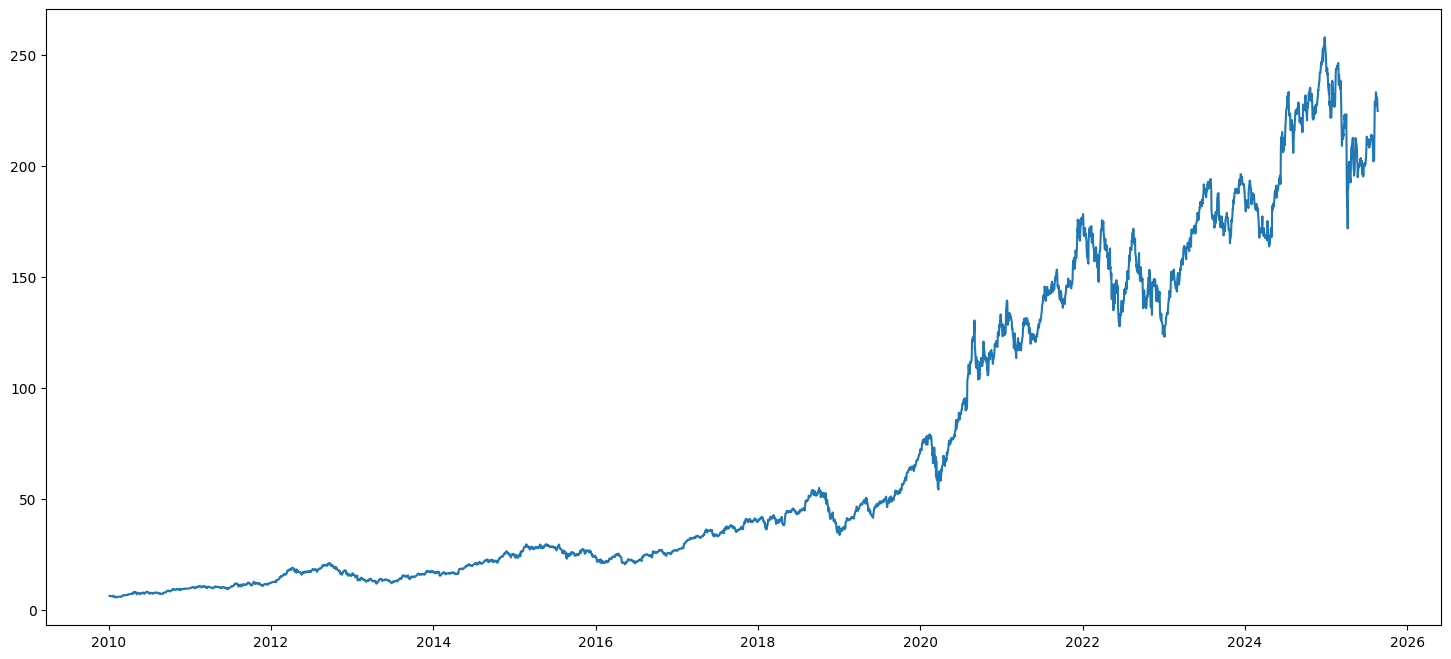

In [27]:
plt.figure(figsize=(18,8))
plt.plot(df["date"], df["adjusted_close"], label="AAPL Ajustado")

#### Feature engineering

In [7]:
df["ret_1"] = df["adjusted_close"].pct_change()

**Por qué:** mide la variación porcentual de un día al siguiente.   
**Ayuda:** es la señal más básica del movimiento de la acción.

In [8]:
df["target_next"] = df["ret_1"].shift(-1)

**Por qué:** es el retorno del día siguiente.   
**Ayuda:** le dice al modelo qué valor debe intentar predecir usando las features de hoy.

In [9]:
df["sma_10"] = df["adjusted_close"].rolling(10).mean()      #Simple Moving Average

**Por qué:** suaviza el precio de cierre ajustado en los ``últimos 10 días``.   
**Ayuda:** capta la tendencia de corto plazo (si la acción viene subiendo o bajando en ``~2 semanas``).

In [10]:
df["sma_50"] = df["adjusted_close"].rolling(50).mean()

**Por qué:** calcula la media de los ``últimos 50 días``.   
**Ayuda:** muestra la tendencia de medio plazo (``≈ 2 meses`` de trading), más estable y menos ruidosa que la corta.

In [11]:
df["trend_10_50"] = (df["sma_10"] / df["sma_50"]) - 1

**Por qué:** mide la diferencia relativa entre la media corta (10 días) y la larga (50 días).   
**Ayuda:** indica si el mercado está en fase ``alcista`` (sma_10 > sma_50) o ``bajista`` (sma_10 < sma_50).

In [12]:
df["ret_5"] = df["adjusted_close"].pct_change(5)

**Por qué:** mide la variación porcentual del precio en los ``últimos 5 días``.   
**Ayuda:** captura el momentum semanal → si la acción viene subiendo varios días seguidos o retrocediendo.

In [13]:
df["vol_20"] = df["ret_1"].rolling(20).std()

**Por qué:** calcula la desviación estándar de los retornos diarios en una ventana de ``20 días (~1 mes)``.    
**Ayuda:** mide la volatilidad reciente → si la acción está tranquila o en una fase con grandes movimientos.

In [14]:
delta = df["adjusted_close"].diff()
up = delta.clip(lower=0).rolling(14).mean()
down = -delta.clip(upper=0).rolling(14).mean()
rs = up / down
df["rsi_14"] = 100 - (100 / (1 + rs))               # RSI = Relative Strength Index

**Por qué:** compara la magnitud de las subidas frente a las bajadas en los ``últimos 14 días``.   
**Ayuda:** mide el momentum → valores >70 sugieren sobrecompra, <30 sobreventa.

In [15]:
df["gap_open"] = (df["open"] / df["adjusted_close"].shift(1)) - 1

**Qué mide:** el salto ``overnight``: noticias, resultados, guidance o macro que salieron fuera del horario de mercado.   
**Por qué se usa adjusted_close de ayer**: para que dividendos/splits no distorsionen el cálculo.   
**Cómo ayuda al modelo**: aporta información nueva que no está en el cierre previo; gaps grandes suelen venir con continuidad o reversión intradía al día siguiente.

In [16]:
df["range_intraday"] = (df["high"] - df["low"]) / df["close"]

**Qué mide:** cuán amplio fue el movimiento del día (del mínimo al máximo) relativo al cierre.   
**Por qué usar close en el denominador:** normaliza la amplitud para compararla entre días con distintos niveles de precio.   
**Cómo ayuda al modelo:** días con rango grande suelen indicar alta actividad/volatilidad; a veces anticipan continuidad del movimiento o reversiones al día siguiente.

In [17]:
vol_mean_20 = df["volume"].rolling(20).mean()
vol_std_20  = df["volume"].rolling(20).std()
df["volume_z"] = (df["volume"] - vol_mean_20) / vol_std_20

``¿Qué es el volumen?``

En tu CSV tienes una columna volume = cuántas acciones de Apple se negociaron ese día.
Ejemplo:

Día normal → 80 millones de acciones.

Día con resultados → 200 millones de acciones.

El volumen es importante porque dice cuánto interés hay en el mercado.


``¿Qué problema hay?``

El volumen en sí mismo es muy variable (no puedes compararlo fácilmente entre días).
Por ejemplo, 120 millones puede ser mucho en una semana tranquila, pero poco en época de resultados.


``Cómo interpretarlo``

volume_z ≈ 0 → volumen normal (nada especial).

volume_z > +2 → volumen mucho más alto de lo habitual → señal de noticias, resultados, compras grandes.

volume_z < -2 → volumen mucho más bajo de lo habitual → desinterés o feriado cercano.


``¿Por qué ayuda al modelo?``

El precio + volumen juntos son más informativos:

Una subida con volumen alto suele ser más “fuerte” (el mercado apoya el movimiento).

Una subida con volumen bajo puede ser menos fiable (poca participación).

In [18]:
df = df.dropna().reset_index(drop=True)
df

,date,open,high,low,close,adjusted_close,volume,ret_1,target_next,sma_10,sma_50,trend_10_50,ret_5,vol_20,rsi_14,gap_open,range_intraday,volume_z
0,2010-03-16,224.17920000,224.98000000,222.51040000,224.45080000,6.73810000,446908000,0.00273822,-0.00148410,6.62342000,6.21290200,0.06607508,0.00642261,0.01263936,90.19696117,32.36148935,0.01100286,-0.44531652
1,2010-03-17,224.89880000,226.45000000,223.26920000,224.12040000,6.72810000,450956800,-0.00148410,0.00236322,6.66782000,6.21897200,0.07217399,-0.00320014,0.01255038,88.68562107,32.37718348,0.01419237,-0.42514059
2,2010-03-18,224.10080000,224.99960000,222.61120000,224.64960000,6.74400000,342109600,0.00236322,-0.01067616,6.70966000,6.22513800,0.07783313,-0.00378161,0.01254416,87.79230576,32.30818507,0.01063167,-1.06979767
3,2010-03-19,224.78960000,225.24040000,221.23080000,222.25000000,6.67200000,559445600,-0.01067616,0.01124101,6.71957000,6.23191200,0.07825175,-0.01919854,0.01279490,77.03381774,32.33179122,0.01804094,0.24380427
4,2010-03-22,220.46920000,225.99920000,220.15000000,224.75040000,6.74700000,456419600,0.01124101,0.01606640,6.73659000,6.24042000,0.07950907,0.00406268,0.01258815,79.56882666,32.04394484,0.02602532,-0.43151782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,2025-08-14,234.06000000,235.12000000,230.85000000,232.78000000,232.78000000,51916300,-0.00235718,-0.00511212,219.27790000,208.79537800,0.05020476,0.05914717,0.01836308,69.84299750,0.00312862,0.01834350,-0.48598290
3879,2025-08-15,234.00000000,234.28000000,229.34000000,231.59000000,231.59000000,56038700,-0.00511212,-0.00302258,222.22184000,209.37537600,0.06135614,0.01091274,0.01851187,68.05163323,0.00524100,0.02133080,-0.33095113
3880,2025-08-18,231.70000000,233.12000000,230.11000000,230.89000000,230.89000000,37476200,-0.00302258,-0.00142925,224.99889000,209.98512400,0.07149919,0.01633066,0.01859114,71.04728233,0.00047498,0.01303651,-1.05693955
3881,2025-08-19,231.28000000,232.87000000,229.35000000,230.56000000,230.56000000,39402600,-0.00142925,-0.01973456,227.78589000,210.52254800,0.08200234,0.00396255,0.01860052,74.00818709,0.00168912,0.01526718,-0.95159874


<Axes: >

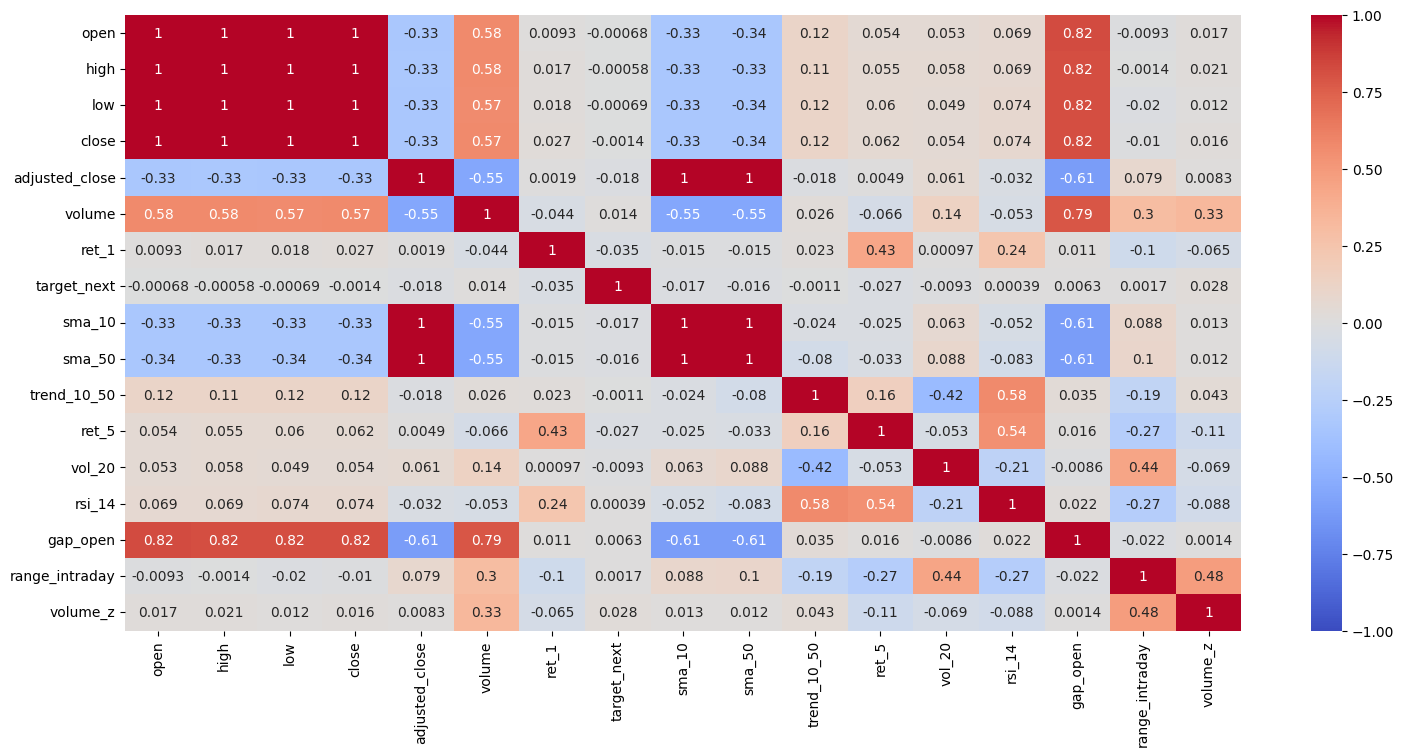

In [19]:
plt.figure(figsize=(18,8))
sns.heatmap(df.drop(columns='date').corr(), vmin=-1, annot=True, cmap = 'coolwarm')

In [20]:
features = ["ret_1","ret_5","sma_10","sma_50","trend_10_50","vol_20","rsi_14","gap_open","range_intraday","volume_z"]

X = df[features]
y = df["target_next"]

In [21]:
split_date = '2023-12-31'

X_train = X[df['date'] <= split_date]
y_train = y[df['date'] <= split_date]
X_test = X[df['date'] > split_date]
y_test = y[df['date'] > split_date]